# Load & Group Tracks

In [22]:
setwd("~/Documents/Upd-Germline")

In [23]:
source("_targets.R")
library(matrixStats)
library(GenomicRanges)

tar_load(chic.tile.diameter_1000_chr)
tar_load(repli.peaks_chr)
tar_load(repli.static.timing.peaks)
tar_load(repli.timing_Germline_chr)
tar_load(repli.timing_Somatic_chr)
tar_load(repli.timing_Kc167_chr)
tar_load(repli.timing_S2_chr)

feature_width <- 10
Y <- tibble(
  seqnames = as.factor(seqnames(chic.tile.diameter_1000_chr)),
  as_tibble(
    sapply(
      repli.peaks_chr[-7],
      \(gr) tibble(
        m = as.list(findOverlaps(chic.tile.diameter_1000_chr, gr)),
        n = rep(NA, length(chic.tile.diameter_1000_chr)) %>%
          replace(
            which(sapply(m, length) != 0),
            names(gr)[sapply(subset(m, sapply(m, length) != 0), \(v) head(v, 1))]
          )
      )$n
    )
  ),
  tibble(
    m = as.list(findOverlaps(chic.tile.diameter_1000_chr, repli.static.timing.peaks)),
    Static = rep(NA, length(chic.tile.diameter_1000_chr)) %>%
      replace(
        which(sapply(m, length) != 0),
        as.character(sapply(subset(m, sapply(m, length) != 0), \(v) head(v, 1)))
      )
  )["Static"],
  GSC = repli.timing_Germline_chr$score,
  CySC = repli.timing_Somatic_chr$score,
  Kc167 = repli.timing_Kc167_chr$score,
  S2 = repli.timing_S2_chr$score,
)
Y <- tibble(
  Y[1:8],
  i = c(
    TRUE,
    rowSums(abs(colDiffs(matrix(as.numeric(is.na(as.matrix(Y[2:8]))), nrow = nrow(Y))))) != 0
  ) %>%
    cumsum(),
  bg_group = Y[2:8] %>%
    split(i) %>%
    sapply(
      \(df) if (all(is.na(as.matrix(df)))) {
        factor(floor((seq(nrow(df)) - 1) / feature_width) * feature_width)
      } else {
        factor(rep("0", nrow(df)))
      }
    ) %>%
    do.call(c, .),
  Y[9:ncol(Y)],
) %>%
  group_by(
    seqnames, Germline_Somatic, Germline_Kc167, Germline_S2,
    Somatic_Kc167, Somatic_S2, Kc167_S2, Static, i, bg_group
  )

# Create Individuals (10 kb cuts or Peaks) and Apply Mean of Region

In [24]:
indiv <- tibble(
  Y[1:8],
  rowname = simplify2array(group_map(Y, \(x, y) length(x$GSC))) %>%
    rep(seq_along(.), .),
  start = start(chic.tile.diameter_1000_chr), end = end(chic.tile.diameter_1000_chr),
  Y[11:14],
) %>%
  group_by(seqnames, rowname) %>%
  summarise(
    n = length(GSC),
    start = min(start),
    end = max(end),
    across(c(GSC, CySC, Kc167, S2), mean),
    Static = !is.na(Static[1]),
    Stem = any(!is.na(c(Germline_Kc167, Germline_S2)) & any(!is.na(c(Somatic_Kc167, Somatic_S2)))),
    GSC_Diff = any(!is.na(c(Germline_Somatic, Germline_Kc167, Germline_S2))),
    Kc_Diff = any(!is.na(c(Germline_Kc167, Kc167_S2))),
    Grand_Mean = TRUE,
    .groups = "drop"
  )
ov <- findOverlaps(
  GRanges(indiv$seqnames, IRanges(indiv$start, indiv$end)) %>%
    GenomicRanges::resize(width = width(.) + 10000, fix = "center"),
  chic.tile.diameter_1000_chr
)
indiv[c("GSC", "CySC", "Kc167", "S2")] <- sapply(
  list(
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr,
    repli.timing_Kc167_chr,
    repli.timing_S2_chr
  ),
  \(tr) split(
    tr$score[to(ov)],
    from(ov)
  ) %>%
    sapply(mean)
)

# Create A Strip of Guides

In [25]:
indiv$Static <- indiv$Static %>%
  which() %>%
  replace(
    0 * indiv$start,
    .,
    rowMeans(cbind(indiv$GSC, indiv$CySC, indiv$Kc167, indiv$S2)[., ])
  )
indiv$Stem <- indiv$Stem %>%
  which() %>%
  replace(
    0 * indiv$start,
    .,
    rowMeans(cbind(indiv$GSC, indiv$CySC)[., ])
  )
indiv$GSC_Diff <- indiv$GSC_Diff %>%
  which() %>%
  replace(
    0 * indiv$start,
    .,
    indiv$GSC[.] - indiv$CySC[.]
  )
indiv$Kc_Diff <- indiv$Kc_Diff %>%
  which() %>%
  replace(
    0 * indiv$start,
    .,
    indiv$Kc167[.] - rowMeans(cbind(indiv$GSC[.], indiv$S2[.]))
  )
indiv$Grand_Mean <- indiv$Grand_Mean %>%
  which() %>%
  replace(
    0 * indiv$start,
    .,
    rowMeans(cbind(indiv$GSC, indiv$CySC, indiv$Kc167, indiv$S2)[., ])
  )
indiv <- mutate(
  rowwise(indiv),
  Test_Feature = t(
    c(
      Static_Early = pmax(0, Static),
      GSC_CySC_Early = pmax(0, Stem),
      GSC_Early = pmax(0, GSC_Diff),
      CySC_Early = pmax(0, -GSC_Diff),
      Kc167_Early = pmax(0, Kc_Diff),
      Kc167_Late = pmax(0, -Kc_Diff),
      GSC_CySC_Late = pmax(0, -Stem),
      Static_Late = pmax(0, -Static)
    ) %>%
      c(Other = all(. == 0))
  )
) %>%
  ungroup() %>%
  mutate(
    Peak = Test_Feature %>%
      `/`(rep(colMeans(. != 0), each = nrow(.))) %>%
      apply(
        1, \(v) c(
          "Static_Early",
          "GSC_CySC_Early",
          "GSC_Early",
          "CySC_Early",
          "Kc167_Early",
          "Kc167_Late",
          "GSC_CySC_Late",
          "Static_Late",
          "Other"
        )[which.max(v)]
      )
  )

In [26]:
print(indiv)

# A tibble: 11,640 x 16
   seqnames rowname     n start   end   GSC  CySC Kc167    S2 Static  Stem
   <fct>      <int> <int> <int> <int> <dbl> <dbl> <dbl> <dbl>  <dbl> <dbl>
 1 2L             1     6     1  6000 0.638 0.562 0.497 0.384      0     0
 2 2L             2     1  6001  7000 0.635 0.538 0.477 0.349      0     0
 3 2L             3     9  7001 16000 0.701 0.511 0.370 0.265      0     0
 4 2L             4     4 16001 20000 0.690 0.512 0.250 0.224      0     0
 5 2L             5    36 20001 56000 0.656 0.456 0.215 0.275      0     0
 6 2L             6     3 56001 59000 0.655 0.404 0.362 0.366      0     0
 7 2L             7     1 59001 60000 0.693 0.522 0.580 0.368      0     0
 8 2L             8     7 60001 67000 0.707 0.550 0.779 0.357      0     0
 9 2L             9     6 67001 73000 0.740 0.594 0.908 0.456      0     0
10 2L            10    12 73001 85000 0.724 0.581 0.916 0.631      0     0
# i 11,630 more rows
# i 5 more variables: GSC_Diff <dbl>, Kc_Diff <dbl>, Gr

# Create Smoothed Quantity for Sorting

In [27]:
log2 <- \(x) log(x) / log(2)
exp2 <- \(x) 2^x
step <- 1000
fft.lengths <- round(exp2(ceiling(log2(chr.lengths / step))))
smooth_values <- \(x, y, to, bw) {
  if (sum(y > 0) >= 2) {
    positive <- density(
      x[y > 0],
      weights = y[y > 0],
      from = 1,
      to = 1 + to * step,
      n = to,
      bw = bw
    )
  } else {
    positive <- list(y = pmax(0, y))
  }
  if (sum(y < 0) >= 2) {
    negative <- density(
      x[y < 0],
      weights = -y[y < 0],
      from = 1,
      to = 1 + to * step,
      n = to,
      bw = bw
    )
  } else {
    negative <- list(y = pmax(0, -y))
  }
  xout <- round(x / step + 1)
  positive$y[xout] - negative$y[xout]
}
indiv <- indiv %>%
  group_by(seqnames) %>%
  reframe(
    rowname,
    n,
    start,
    end,
    GSC,
    CySC,
    Kc167,
    S2,
    across(
      c(Static, Stem, GSC_Diff, Kc_Diff),
      \(v) if (seqnames[1] %in% names(fft.lengths)) {
        smooth_values(
          x = mapply(
            \(start, end) seq(start, end + 1, by = 1000),
            start,
            end,
            SIMPLIFY = FALSE
          ) %>%
            do.call(c, .),
          y = rep(
            v,
            times = 1 + floor((end + 1 - start) / 1000)
          ),
          to = fft.lengths[seqnames[1]],
          bw = 100000
        ) %>%
          split(rep(seq_along(v), times = 1 + floor((end + 1 - start) / 1000))) %>%
          sapply(\(v) v[which.max(abs(v))]) %>%
          replace(v != 0, v[v != 0])
      } else {
        v
      }
    ),
    Grand_Mean,
    Test_Feature,
    Peak,
  )

mult <- 10
library(withr)
sortperm <- order(
  mult^4 * indiv$Static +
    mult^3 * indiv$Stem +
    mult^2 * indiv$GSC_Diff +
    mult * indiv$Kc_Diff +
    indiv$Grand_Mean +
    with_seed(0, runif(length(indiv$Static), min = 0, max = 1e-10))
)

Warning message:
"There were 51 warnings in `reframe()`.
The first warning was:
i In argument: `across(...)`.
i In group 1: `seqnames = 2L`.
Caused by warning in `density.default()`:
! sum(weights) != 1  -- will not get true density
i Run `dplyr::last_dplyr_warnings()` to see the 50 remaining warnings."


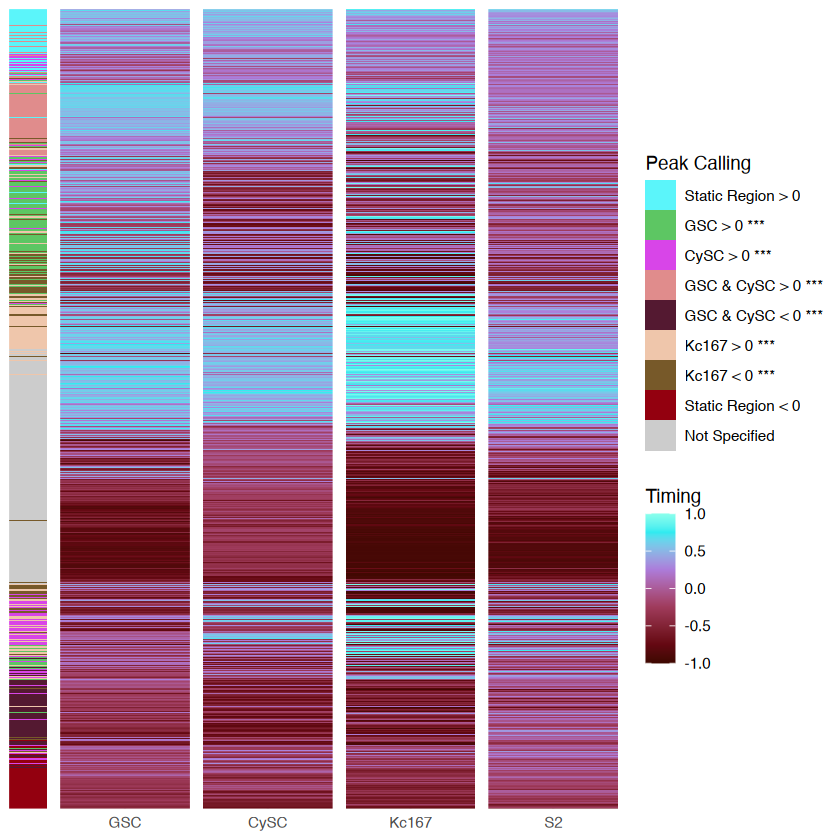

In [28]:
library(ggnewscale)
library(ggplot2)
library(reshape2)
Classification_Color <- c(
  Static_Early = "#5bf5fa",
  GSC_Early = "#5DC663",
  CySC_Early = "#D845E8",
  GSC_CySC_Early = "#e08c8c",
  GSC_CySC_Late = "#541931",
  Kc167_Early = "#efc6ab",
  Kc167_Late = "#775929",
  Static_Late = "#93000f",
  Other = "#cccccc"
)
Classification_Label <- c(
  Static_Early = "Static Region > 0",
  GSC_Early = "GSC > 0 ***",
  CySC_Early = "CySC > 0 ***",
  GSC_CySC_Early = "GSC & CySC > 0 ***",
  GSC_CySC_Late = "GSC & CySC < 0 ***",
  Kc167_Early = "Kc167 > 0 ***",
  Kc167_Late = "Kc167 < 0 ***",
  Static_Late = "Static Region < 0",
  Other = "Not Specified"
)
xs <- 1 + 1.1 * seq(0, 4)
width <- unit(4, "in")
height <- unit(4, "in")
strip_width <- unit(0.25, "in")
# Solve this:
# W / (R + W) = strip_width / width
# -> W = strip_width / width * (R + W)
# -> (1 - strip_width / width) * W = strip_width / width * R
# -> W = strip_width / width * R / (1 - strip_width / width)
# where R (the right-side) is max(xs) - min(xs)
strip_width_plot_units <- as.numeric(strip_width) / as.numeric(width) *
  (max(xs) - min(xs)) /
  (1 - as.numeric(strip_width) / as.numeric(width))
xlim <- c(1.5 - strip_width_plot_units, max(xs) + 0.5)
M <- as.matrix(indiv[sortperm, c("GSC", "CySC", "Kc167", "S2")])
p <- ggplot(
  melt(M) %>% tibble(x = xs[1 + as.numeric(Var2)]),
  aes(x, Var1)
) +
  geom_raster(aes(fill = Peak), tibble(x = xs[1], Var1 = seq_along(indiv$Peak), Peak = factor(indiv$Peak[sortperm], names(Classification_Color)))) +
  scale_fill_manual(
    values = Classification_Color,
    labels = Classification_Label,
    guide = guide_legend("Peak Calling")
  ) +
  new_scale_fill() +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[2])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[3])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[4])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[5])) +
  scale_x_continuous(
    breaks = xs[-1],
    labels = colnames(M),
    minor_breaks = NULL
  ) +
  scale_y_continuous(breaks = NULL, minor_breaks = NULL) +
  scale_fill_gradientn(
      colors = c(
        hcl(30, 40, 10),
        repli_level_colors$L,
        repli_level_colors$ML,
        repli_level_colors$EM,
        repli_level_colors$E,
        hcl(170, 55, 95)
      ),
      values = c(0, 0.125, 0.375, 0.625, 0.875, 1),
      guide = guide_colorbar(title = "Timing"),
      limits = c(-1, 1)
    ) +
  coord_cartesian(xlim, expand = F) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    legend.key.size = strip_width
  )
p


# Recapitulate Colv

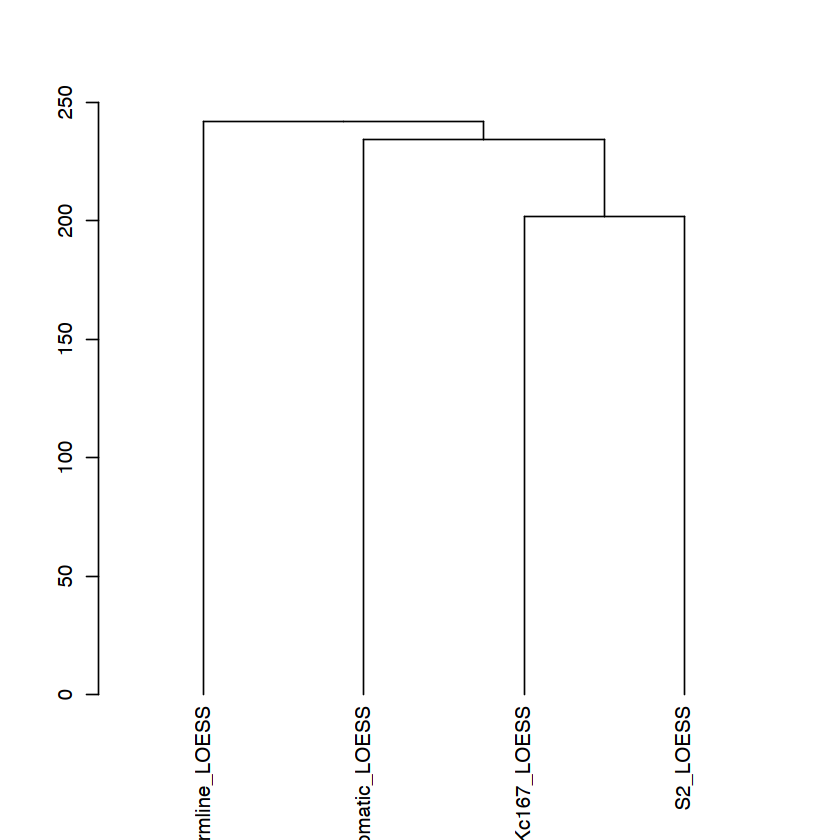

In [29]:
library(dplyr)
library(GenomicRanges)
library(targets)
source("_targets.R")
tar_load(chic.tile.diameter_1000_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

Y <- tibble(
  chr = names(chr.lengths),
  xmin = 2500,
  xmax = floor((chr.lengths - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = 0.025
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))
YMEAN <- Y %>%
  group_by(region) %>%
  summarise(across(matches("LOESS"), mean))

YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)

Colv <- as.dendrogram(hclust(dist(t(YS)), "average"))
plot(Colv)

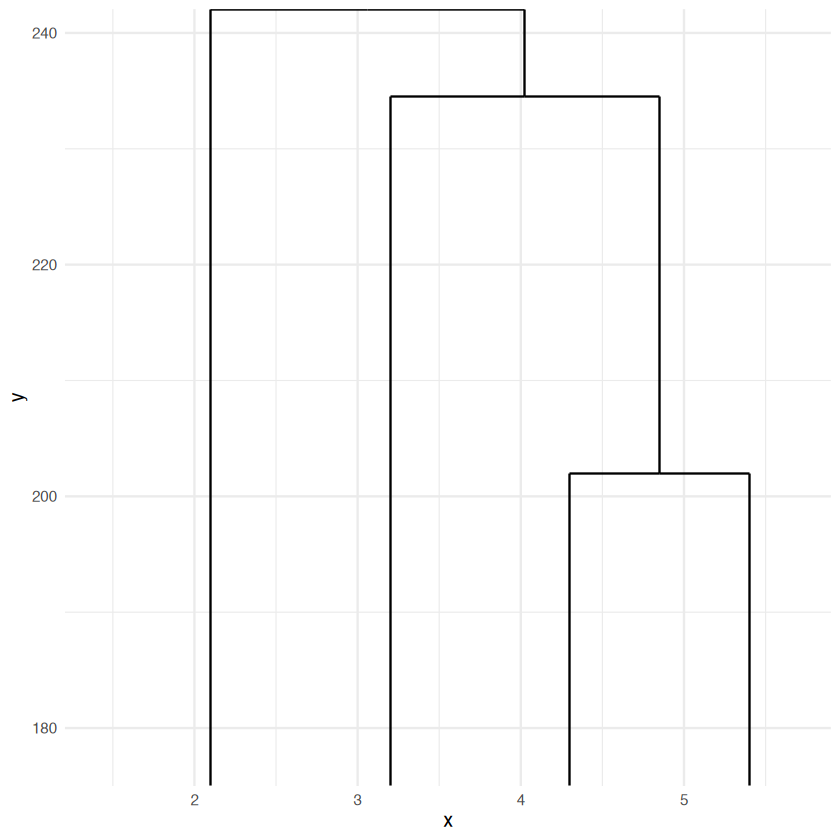

In [30]:
library(ggdendro)

ColPlot <- Colv
i <- 1
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 2)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
Y_Margin <- segment(dendro_data(ColPlot, type = "rectangle")) %>%
  mutate(
    across(
      c(x, xend),
      \(v) (v - 1) * diff(head(xs, 2)) + xs[2]
    )
  ) %>%
  ggplot(aes(x, y, xend = xend, yend = yend)) +
  geom_segment() +
  coord_cartesian(xlim, NULL, ex=F) +
  theme_void()
Y_Margin + theme_minimal()

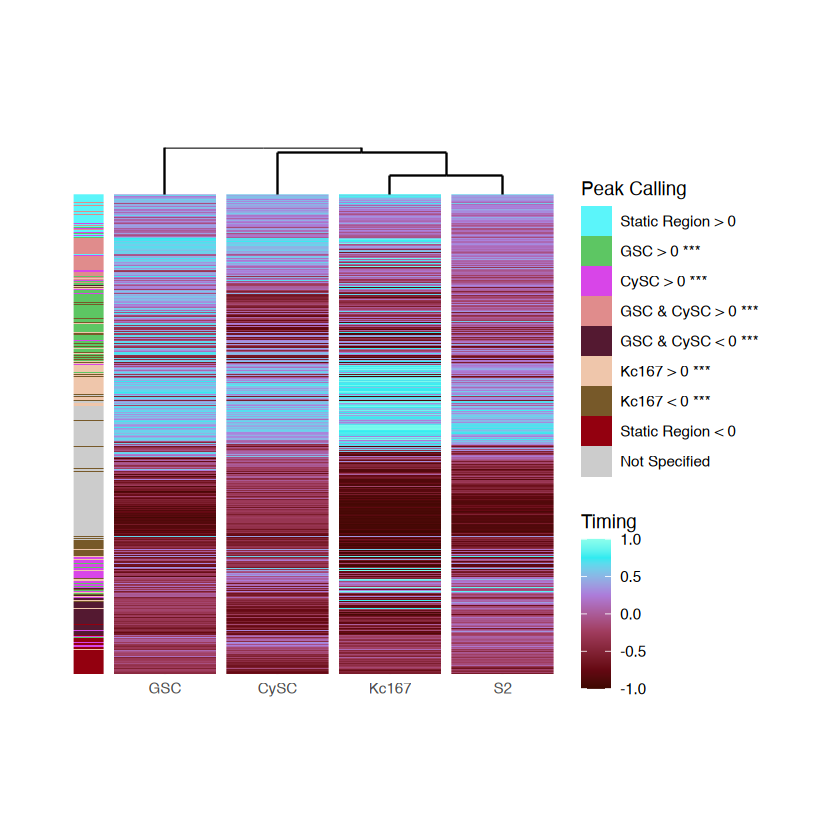

In [31]:
library(egg)
library(grid)
library(gtable)
grob <- set_panel_size(p, w = width, h=height)
grob$heights[1] <- unit(0.5, "in")
grob <- grob %>%
  gtable_add_grob(
    list(ggplotGrob(Y_Margin + theme(plot.margin = margin(8, 0, 0, 0)))),
    t = 1,
    l = 7
  )
grid.draw(grob)

In [32]:
ggsave("illustrations/Repli-Heatmap.pdf", grob, w=6, h=6)

In [33]:
(indiv$end - indiv$start + 1) %>% split(rowAnys(indiv$Test_Feature[, 1:8] != 0)) %>% sapply(sum) %>% `/`(sum(.))

FALSE      TRUE 
0.1448143 0.8551857

In [34]:
table(rowAnys(indiv$Test_Feature[, 1:8] != 0)) %>%
  prop.table()


   FALSE     TRUE 
0.275945 0.724055 

In [38]:
with(indiv, quantile(end - start + 1, c(0.005, 0.025, 0.5, 0.975, 0.995))) %>%
  print()

 0.5%  2.5%   50% 97.5% 99.5% 
 1000  1000 10000 50000 84805 


In [42]:
colSums(indiv$Test_Feature)

[1]  285.5098  560.3609 1647.6612  811.2823 1001.1895 1514.3186  638.2914
[8]  249.8805 3212.0000

In [47]:
dim(indiv$Test_Feature)

[1] 11640     9

In [45]:
with(
  subset(indiv, rowAlls(indiv$Test_Feature[, -9] == 0)),
  quantile(end - start + 1, c(0.005, 0.025, 0.5, 0.975, 0.995))
) %>%
  print()

   0.5%    2.5%     50%   97.5%   99.5% 
 1000.0  1000.0  2688.5 31000.0 52000.0 


In [48]:
with(
  subset(indiv, rowAlls(indiv$Test_Feature[, -9] == 0)),
  mean((end - start + 1) == 10000)
)

[1] 0.09090909

In [49]:
with(
  subset(indiv, rowAnys(indiv$Test_Feature[, -9] != 0)),
  mean((end - start + 1) == 10000)
)

[1] 0.2134551

In [46]:
with(
  subset(indiv, rowAnys(indiv$Test_Feature[, -9] != 0)),
  quantile(end - start + 1, c(0.005, 0.025, 0.5, 0.975, 0.995))
) %>%
  print()

 0.5%  2.5%   50% 97.5% 99.5% 
 1000  1000 10000 55000 89000 


In [39]:
tail(sort(with(indiv, end - start + 1)))

[1] 131000 137000 139000 148000 170000 191000